# Descriptive Analytics- Ethereum Whales

## Prepare Notebook

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import networkx as nx
from pyvis import network as net
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup as soup
import time
from IPython.display import display
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")


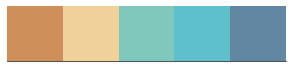

In [218]:
# Color palette
my_colors = ["#ce8f5a", "#efd199", "#80c8bc", "#5ec0ca", "#6287a2"]
sns.palplot(sns.color_palette(my_colors))

# Set Style. Inpired on https://www.kaggle.com/code/andradaolteanu/bitcoin-dogecoin-on-rapids-and-elon-musk
sns.set_style("white")
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

class color:
    BOLD = '\033[1m' + '\033[93m'
    END = '\033[0m'

In [260]:
# Get nametag with the addresses from Etherscan through crawler. This is perform to identify easier which are the names of the addresses, if available.
def get_nametag(address):
    #Make API request to Etherscan
    url = 'https://etherscan.io/address/%s'%(address) # Initiate with the first page of accounts with 100 records
    req = Request(url,headers={'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'})   # Etherscan restricts the access for Webscrapping, reason why headers needs to be stated
    response = urlopen(req, timeout=500).read() # Read response
    page_soup = soup(response, "html.parser") # Parse HTML response
    page_soup.find('title')
    a=page_soup.find('title')
    a=str(a)
    a=((a.split('|')[0])[10:])[:-1]
    time.sleep(2) # Etherscan restricts the access if the requests are perform too fast. The function delays the code by two seconds
    return a

# Define function to get value in bars in plots
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''

    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center")
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)



## Prepare Dataset

In [4]:
# Load data from balances
network_data=pd.read_csv('C:/Users/JCRG/Desktop/Master/Dissertation/Data/Transactional_Network_Ether.csv')
network_data.head()

,from_address,to_address,block_timestamp,value_ether
0,0x7ac34681f6aaeb691e150c43ee494177c0e2c183,0x7fb6fefe6c524d9cb06025583c0ad59aad2f6f5b,2018-07-11 11:57:20 UTC,1.00000
1,0xf1cf296c11d3b010e6dd3d48b6c5aaed613e96f1,0x2ec2c8729da460eb9743e86c3d16713f6aa47325,2018-07-11 01:53:49 UTC,3.04768
2,0x8e04af7f7c76daa9ab429b1340e0327b5b835748,0x0000000000085d4780b73119b644ae5ecd22b376,2019-08-20 14:27:26 UTC,0.00000
3,0x8f6147a13514d7cc7c1c85bc4fad8f7f1bc63b57,0x0d8775f648430679a709e98d2b0cb6250d2887ef,2019-05-30 03:04:18 UTC,0.00000
4,0x7b6f730249555a85d39327b90f0080e9dc63daff,0x1cb9ede1a43ab0265d6c44be4f3db554abf822c5,2019-05-30 13:17:56 UTC,250.00000


In [5]:
# Merge data with the transactional data from addresses and filter out the addresses that are not in the listings
# Configure time format for block_timestamp date
network_data['block_timestamp']=pd.to_datetime(network_data['block_timestamp'],infer_datetime_format=True)
network_data['block_timestamp']=network_data['block_timestamp'].dt.date
network_data['block_timestamp']=pd.to_datetime(network_data['block_timestamp'],infer_datetime_format=True)

## Plots

### Count of Transactions per Day of Gop 10,000 Whales in Ethereum

In [6]:
# Calculate dataframe with data with counts of transactions per day
df_date_count=network_data.groupby('block_timestamp').value_ether.count().reset_index().sort_values(by='block_timestamp',ascending=False)

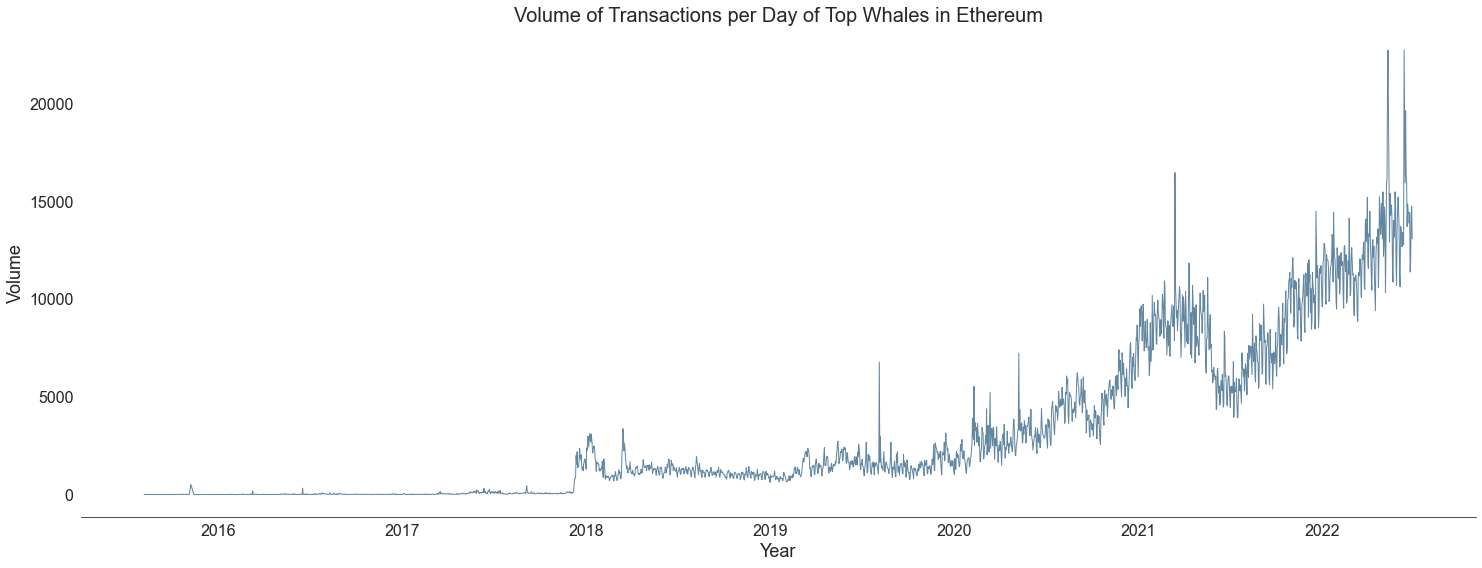

In [7]:
# Plot
plt.figure(figsize=(25, 9))
ax = sns.lineplot(data=df_date_count, x="block_timestamp", y="value_ether", lw=1, color=my_colors[4])
plt.title("Volume of Transactions per Day of Top Whales in Ethereum", size=20)
plt.xlabel("Year", size=18)
plt.ylabel("Volume", size=18)
sns.despine(left=True)
plt.show()


In [8]:
# Count of current whales in time
df_whales_time=pd.DataFrame(network_data[['from_address','block_timestamp']]).sort_values('block_timestamp').groupby('from_address').first()

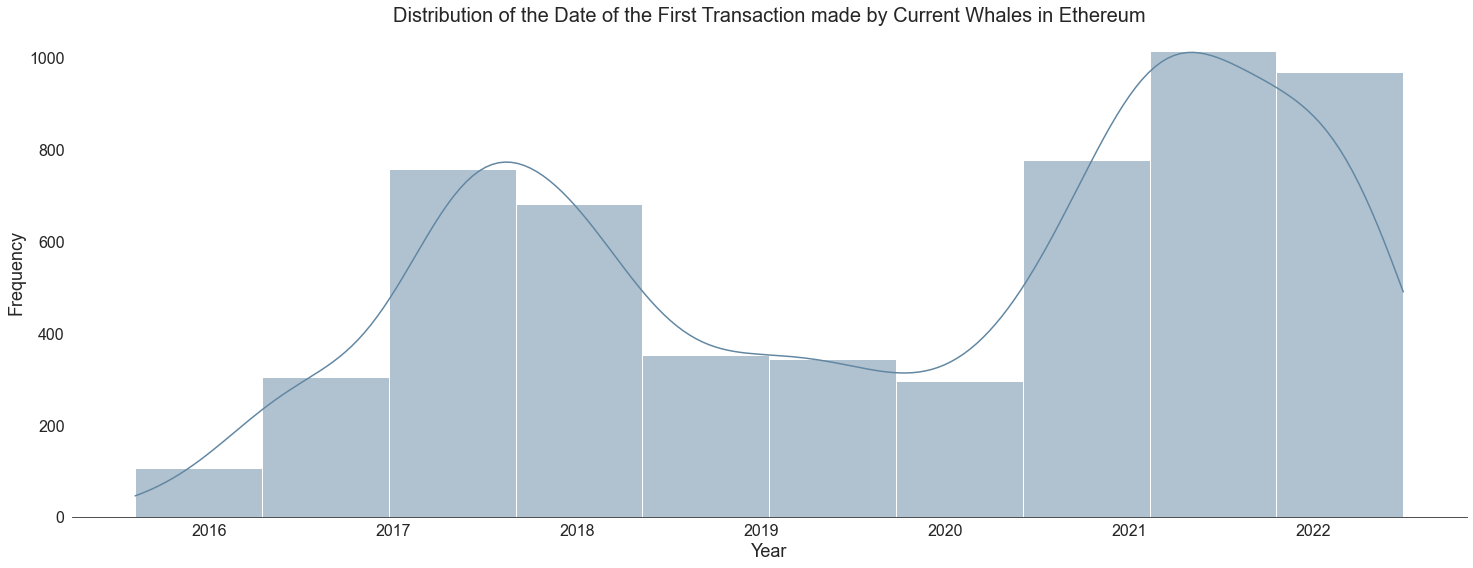

In [9]:
# Plot
plt.figure(figsize=(25, 9))
ax = sns.histplot(data=df_whales_time, x="block_timestamp", color=my_colors[4],kde=True,bins=10)
plt.title("Distribution of the Date of the First Transaction made by Current Whales in Ethereum", size=20)
plt.xlabel("Year", size=18)
plt.ylabel("Frequency", size=18)
sns.despine(left=True)
plt.show()


In [17]:
network_data['year'] = pd.DatetimeIndex(network_data['block_timestamp']).year

In [18]:
network_data

,from_address,to_address,block_timestamp,value_ether,year
0,0x7ac34681f6aaeb691e150c43ee494177c0e2c183,0x7fb6fefe6c524d9cb06025583c0ad59aad2f6f5b,2018-07-11,1.00000,2018
1,0xf1cf296c11d3b010e6dd3d48b6c5aaed613e96f1,0x2ec2c8729da460eb9743e86c3d16713f6aa47325,2018-07-11,3.04768,2018
2,0x8e04af7f7c76daa9ab429b1340e0327b5b835748,0x0000000000085d4780b73119b644ae5ecd22b376,2019-08-20,0.00000,2019
3,0x8f6147a13514d7cc7c1c85bc4fad8f7f1bc63b57,0x0d8775f648430679a709e98d2b0cb6250d2887ef,2019-05-30,0.00000,2019
4,0x7b6f730249555a85d39327b90f0080e9dc63daff,0x1cb9ede1a43ab0265d6c44be4f3db554abf822c5,2019-05-30,250.00000,2019
...,...,...,...,...,...
7708063,0xffff46e05a09314daae9176fc32dba0f4172dcdb,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,2020-10-26,0.00000,2020
7708064,0xffff46e05a09314daae9176fc32dba0f4172dcdb,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,2020-10-26,0.00000,2020
7708065,0xffff46e05a09314daae9176fc32dba0f4172dcdb,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,2020-10-26,0.00000,2020
7708066,0xffff46e05a09314daae9176fc32dba0f4172dcdb,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,2020-10-26,0.00000,2020


In [30]:
# Prepare data for network. Group by sender and receiver and count the number of transactions
network_data_grouped=network_data[['from_address','to_address','year','value_ether']].groupby(['from_address','to_address','year']).value_ether.count().reset_index()
network_data_grouped.sort_values(by='value_ether',ascending=False,inplace=True)
network_data_grouped.head(10)

,from_address,to_address,year,value_ether
1856276,0xb8001c3ec9aa1985f6c747e25c28324e4a361ec1,0xdac17f958d2ee523a2206206994597c13d831ec7,2020,94330
406152,0x292f04a44506c2fd49bac032e1ca148c35a478c8,0xdac17f958d2ee523a2206206994597c13d831ec7,2021,58539
1856277,0xb8001c3ec9aa1985f6c747e25c28324e4a361ec1,0xdac17f958d2ee523a2206206994597c13d831ec7,2021,56950
701920,0x6871eacd33fbcfe585009ab64f0795d7152dc5a0,0xdac17f958d2ee523a2206206994597c13d831ec7,2021,51787
1154056,0x7abe0ce388281d2acf297cb089caef3819b13448,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2021,47347
1016348,0x6dfc34609a05bc22319fa4cce1d1e2929548c0d7,0xdac17f958d2ee523a2206206994597c13d831ec7,2022,42693
57742,0x0639556f03714a74a5feeaf5736a4a64ff70d206,0xdac17f958d2ee523a2206206994597c13d831ec7,2020,41242
1154057,0x7abe0ce388281d2acf297cb089caef3819b13448,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2022,35564
1162988,0x7abe0ce388281d2acf297cb089caef3819b13448,0xdac17f958d2ee523a2206206994597c13d831ec7,2021,35348
406153,0x292f04a44506c2fd49bac032e1ca148c35a478c8,0xdac17f958d2ee523a2206206994597c13d831ec7,2022,31342


In [28]:
network_data_grouped.reset_index()

,from_address,to_address,year,value_ether
0,0xb8001c3ec9aa1985f6c747e25c28324e4a361ec1,0xdac17f958d2ee523a2206206994597c13d831ec7,2020,94330
1,0x292f04a44506c2fd49bac032e1ca148c35a478c8,0xdac17f958d2ee523a2206206994597c13d831ec7,2021,58539
2,0xb8001c3ec9aa1985f6c747e25c28324e4a361ec1,0xdac17f958d2ee523a2206206994597c13d831ec7,2021,56950
3,0x6871eacd33fbcfe585009ab64f0795d7152dc5a0,0xdac17f958d2ee523a2206206994597c13d831ec7,2021,51787
4,0x7abe0ce388281d2acf297cb089caef3819b13448,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2021,47347
...,...,...,...,...
2365620,0x6dfc34609a05bc22319fa4cce1d1e2929548c0d7,0xc45d80f050952824e74ac50a1af8bcdaf4a636fe,2021,1
2365621,0x6dfc34609a05bc22319fa4cce1d1e2929548c0d7,0xc45d59cccfd98ed1d7492ddac504e4320c2b38e7,2022,1
2365622,0x6dfc34609a05bc22319fa4cce1d1e2929548c0d7,0xc45d456288ce75f58fc2e1b318b59ce17fef2bd5,2021,1
2365623,0x6dfc34609a05bc22319fa4cce1d1e2929548c0d7,0xc45b60c39868978fcd7120523a02dc773fb07e77,2021,1


In [289]:
network_data_to_address=pd.DataFrame(network_data_grouped['to_address'].drop_duplicates().reset_index(drop=True))

for i in range(2016,2023):
    G = nx.from_pandas_edgelist(network_data_grouped[network_data_grouped['year']==i],
                                source='from_address',
                                target='to_address',
                                create_using=nx.DiGraph)

    # Get the nodes where the top 10,000 whales are transacting with.
    df=pd.DataFrame(G.in_degree())
    df.columns=['to_address',i]
    # Select the top 100 addresses
    network_data_to_address=network_data_to_address.merge(df,on='to_address',how='left')

network_data_to_address=network_data_to_address.sort_values(by=2022,ascending=False)
network_data_to_address

,to_address,2016,2017,2018,2019,2020,2021,2022
0,0xdac17f958d2ee523a2206206994597c13d831ec7,NaN,NaN,2.0,70.0,383.0,827.0,712.0
1,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,NaN,NaN,NaN,46.0,252.0,677.0,696.0
266,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,NaN,NaN,NaN,NaN,NaN,48.0,313.0
38,0x6b175474e89094c44da98b954eedeac495271d0f,NaN,NaN,NaN,33.0,206.0,381.0,301.0
289,0x1111111254fb6c44bac0bed2854e76f90643097d,NaN,NaN,NaN,NaN,NaN,96.0,210.0
...,...,...,...,...,...,...,...,...
2122554,0xc45dec072f665b3b61e4d1494f03e029d518840e,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2122555,0xc45d80f050952824e74ac50a1af8bcdaf4a636fe,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2122557,0xc45d456288ce75f58fc2e1b318b59ce17fef2bd5,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2122558,0xc45b60c39868978fcd7120523a02dc773fb07e77,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [290]:
# Create column with nametag
network_data_to_address=network_data_to_address[:20]
network_data_to_address['tag'] = network_data_to_address['to_address'].apply(get_nametag)
# Convert format of table to long
network_data_to_address=network_data_to_address.melt(id_vars=['to_address','tag'],value_vars=range(2016,2023),var_name='year',value_name='value_ether').sort_values(by='value_ether',ascending=False)

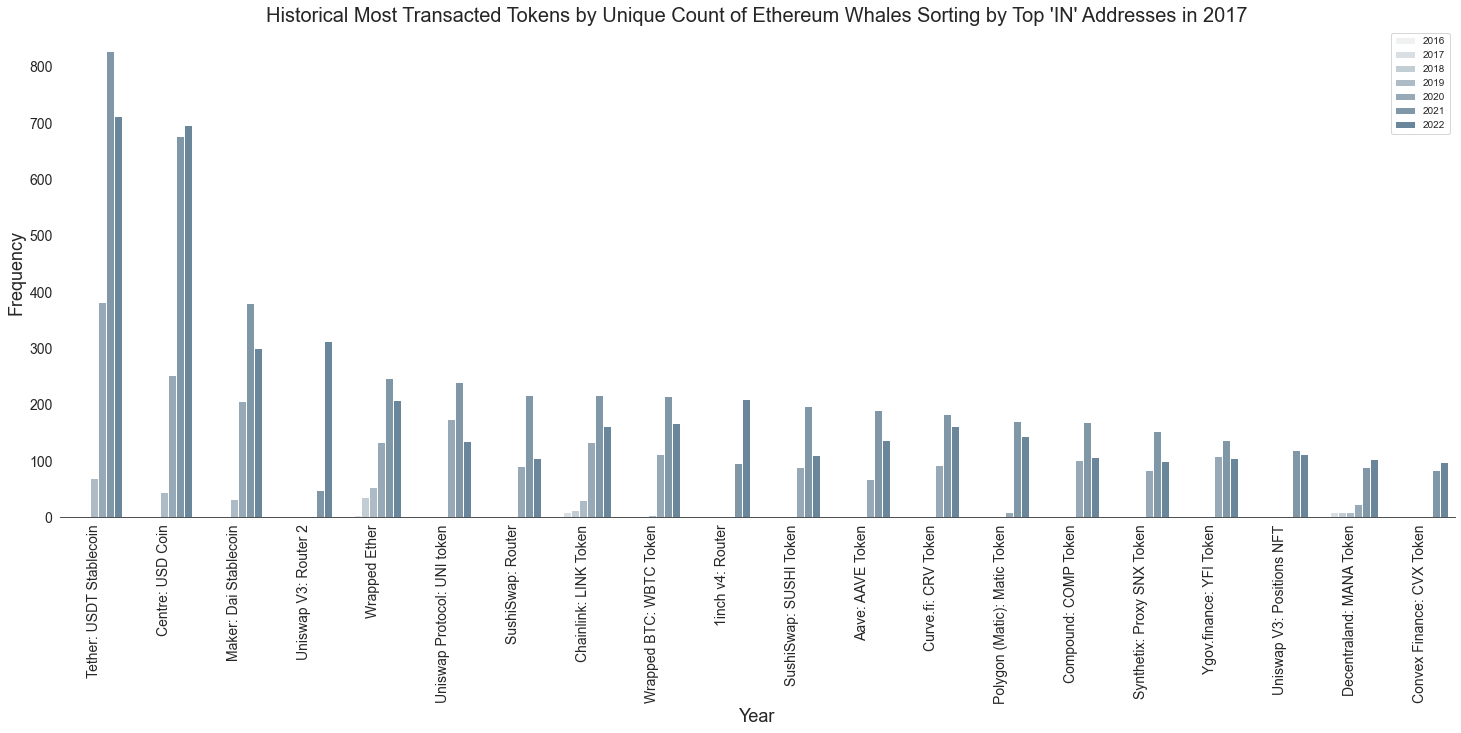

In [291]:
#df_2022.plot(x='tag',y='Count',kind='bar',color=my_colors[4])
# Plot
plt.figure(figsize=(25, 9))
ax = sns.barplot(data=network_data_to_address, x="tag",y='value_ether',hue='year', color=my_colors[4])

plt.title("Historical Most Transacted Tokens by Unique Count of Ethereum Whales Sorting by Top 'IN' Addresses in 2022", size=20)
plt.xlabel("Year", size=18)
plt.ylabel("Frequency", size=18)
plt.xticks(rotation=90)
plt.legend(loc='upper right')
sns.despine(left=True)
plt.show()


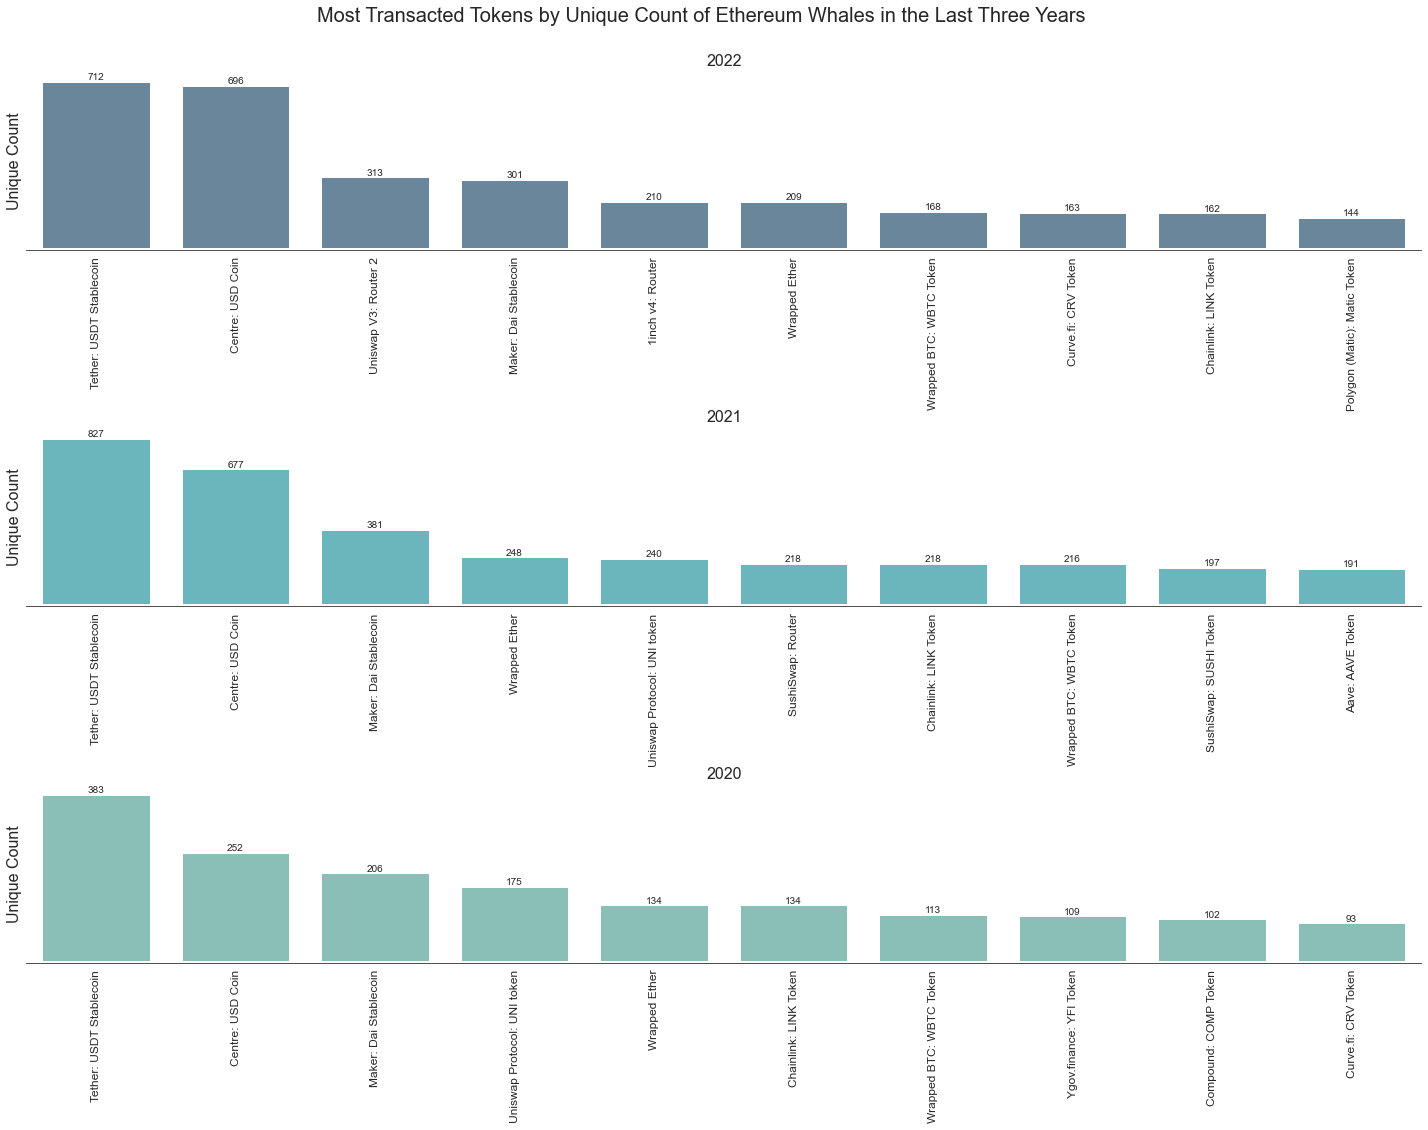

In [292]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(25, 9))
plt.suptitle("Most Transacted Tokens by Unique Count of Ethereum Whales in the Last Three Years", size=20,y=1.6)

#fig.suptitle("\n".join(["a big long suptitle that runs into the title"]), y=1.2)
plt.subplots_adjust(hspace=1,top=1.5)
axs=[ax1,ax2,ax3]

for ax,y,c in zip(axs,range(2022,2019,-1),range(4,0,-1)):
    sns.barplot(data=network_data_to_address[network_data_to_address['year']==y][:10], x="tag", y="value_ether", lw=5, color=my_colors[c], ax=ax)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), size=12,rotation=90)
    ax.set_ylabel("Unique Count", size=16)
    ax.get_yaxis().set_ticks([])

    ax.title.set_text(y)
    ax.title.set_size(16)
    show_values_on_bars(axs=ax, h_v="v", space=0.4)



## Insider Trading

In [47]:
df_insider_trading=pd.read_csv('Insider_Trading_Addresses.csv')
df_insider_trading['from_address'].unique()[:5]

array(['0x024bcbcaad82e67f721799e259ca60bc7d363419',
       '0x0b30483057d6a7798378edba707d625116ed7640',
       '0x0c5a2c72c009252f0e7312f5a1ab87de02be6fbe',
       '0x10b26700b0a2d3f5ef12fa250aba818ee3b43bf4',
       '0x187e3534f461d7c59a7d6899a983a5305b48f93f'], dtype=object)

In [46]:
network_data_grouped_filtered=network_data_grouped[network_data_grouped['from_address'].isin(df_insider_trading['from_address'].unique()[:5])]

In [54]:
network_data_grouped_filtered

,from_address,to_address,value_ether
1799,0x024bcbcaad82e67f721799e259ca60bc7d363419,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,1196
131242,0x0c5a2c72c009252f0e7312f5a1ab87de02be6fbe,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,915
131245,0x0c5a2c72c009252f0e7312f5a1ab87de02be6fbe,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,801
1694,0x024bcbcaad82e67f721799e259ca60bc7d363419,0x2659fcb5494b163693c6ce3cfb64bb8b32025298,404
131587,0x0c5a2c72c009252f0e7312f5a1ab87de02be6fbe,0xdef1c0ded9bec7f1a1670819833240f027b25eff,384
...,...,...,...
287574,0x187e3534f461d7c59a7d6899a983a5305b48f93f,0x05275f42843c2b541d7bb95634264da586d8df68,1
287642,0x187e3534f461d7c59a7d6899a983a5305b48f93f,0x3dd98c8a089dbcff7e8fc8d4f532bd493501ab7f,1
287622,0x187e3534f461d7c59a7d6899a983a5305b48f93f,0x320623b8e4ff03373931769a31fc52a4e78b5d70,1
287606,0x187e3534f461d7c59a7d6899a983a5305b48f93f,0x1b793e49237758dbd8b752afc9eb4b329d5da016,1


In [50]:
# Create object with network data
G = nx.from_pandas_edgelist(network_data_grouped_filtered,
                            source='from_address',
                            target='to_address',
                            create_using=nx.DiGraph)

g=net.Network(notebook=False,height='400px', width='80%',heading='')
g.show_buttons(filter_=True)
g.from_nx(G)
g.show('a.html')